In [1]:
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

confidence_map = {
    "Almost no chance": 0.0,
    "Highly unlikely": 0.1,
    "Chances are slight": 0.2,
    "Unlikely": 0.3,
    "Less than even": 0.4,
    "Better than even": 0.5,
    "Likely": 0.6,
    "Very good chance": 0.7,
    "Highly likely": 0.8,
    "Almost certain": 0.9
}

def parse_conf(text: str) -> float:
    proc_text = text.lower().strip().replace(" ", "")
    for conf_text, conf in confidence_map.items():
        if conf_text.lower().replace(" ", "") in proc_text:
            return conf
    return -1

def load_data(exp: str, model_size: str) -> List[Dict]:
    with open(f"./data/doubt-{exp}-{model_size}.json", "r") as f:
        data = json.load(f)
    return data

exps = ["baseline", "1_4", "mid", "3_4", "end"]
model_sizes = ["1.5", "7", "14"]

rows = []
for exp in exps:
    for model_size in model_sizes:

        data = load_data(exp, model_size)

        for d in data:
            
            conf = parse_conf(d["confidence"])
            
            reason = d["text"].split("<think>")[-1].split("</think>")[0]
            
            if conf == -1:
                # If parsing failed don't include the data point
                # the text is corruped or the context length was
                # exceeded while generation
                continue
                
            rows.append({
                "exp": exp,
                "model_size": model_size,
                "accuracy": d["correct"],
                "confidence": conf,
                "len_reason": len(reason)
            })

df = pd.DataFrame(rows)

## Accuracy and Confidence Plots

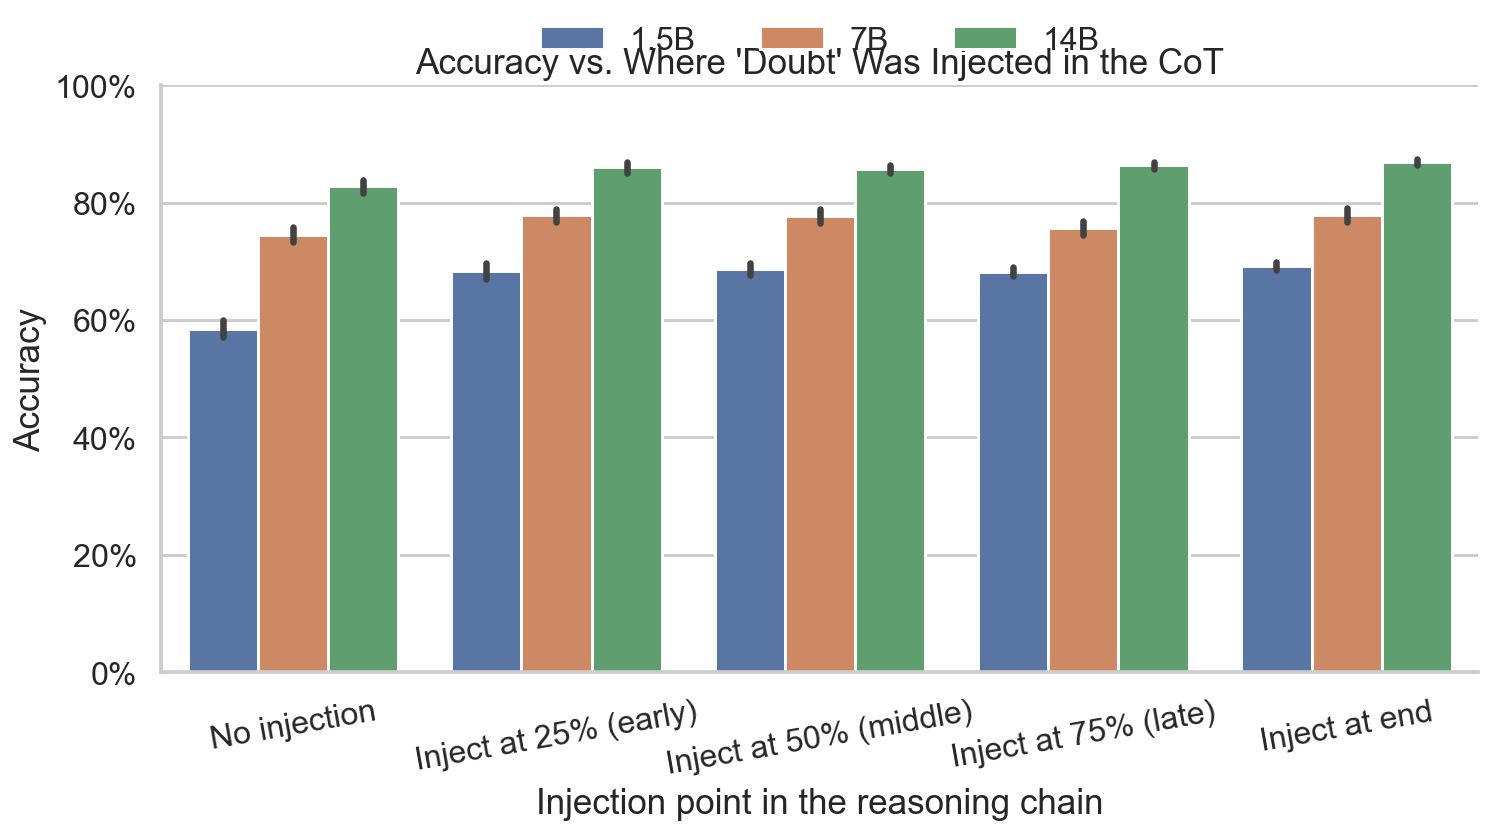

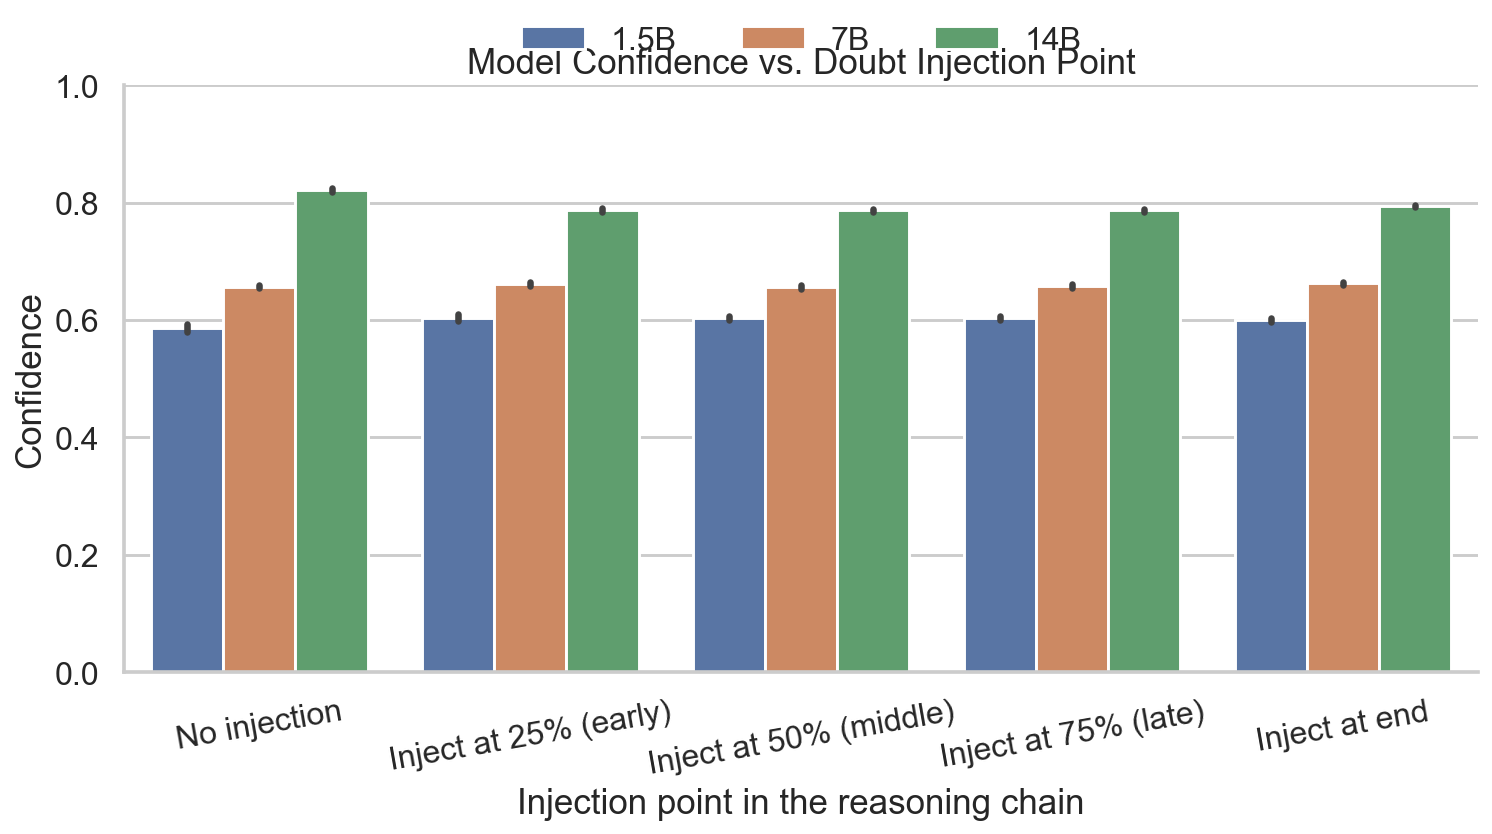

In [9]:
# ---------- audience-friendly plotting ----------
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Friendly labels for experiments and model sizes
exp_order = ["baseline", "1_4", "mid", "3_4", "end"]
exp_long = {
    "baseline": "No injection",
    "1_4":      "Inject at 25% (early)",
    "mid":      "Inject at 50% (middle)",
    "3_4":      "Inject at 75% (late)",
    "end":      "Inject at end",
}
size_map   = {"1.5": "1.5B", "7": "7B", "14": "14B"}
size_order = ["1.5B", "7B", "14B"]

# Apply mappings
df["where_injected"] = pd.Categorical(df["exp"].map(exp_long), categories=[exp_long[e] for e in exp_order], ordered=True)
df["model_size_lbl"] = pd.Categorical(df["model_size"].map(size_map), categories=size_order, ordered=True)

# Shared legend placement
legend_kwargs = dict(ncol=len(size_order), loc="upper center", bbox_to_anchor=(0.5, 1.15), frameon=False)

# --- Accuracy plot ---
plt.figure(figsize=(11, 6.8), dpi=140)
ax = sns.barplot(
    data=df, x="where_injected", y="accuracy", hue="model_size_lbl",
    estimator=np.mean, errorbar="se", hue_order=size_order
)
ax.set_title("Accuracy vs. Where 'Doubt' Was Injected in the CoT")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("Accuracy")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, 1)
ax.legend(**legend_kwargs)
for label in ax.get_xticklabels():
    label.set_rotation(10)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])  # room for legend

# --- Confidence plot ---
plt.figure(figsize=(11, 6.8), dpi=140)
ax = sns.barplot(
    data=df, x="where_injected", y="confidence", hue="model_size_lbl",
    estimator=np.mean, errorbar="se", hue_order=size_order
)
ax.set_title("Model Confidence vs. Doubt Injection Point")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("Confidence")
ax.set_ylim(0, 1)
ax.legend(**legend_kwargs)
for label in ax.get_xticklabels():
    label.set_rotation(10)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Optional: add a brief caption on either plot (uncomment if you want it)
# plt.figtext(0.5, 0.005,
#     "Bars show mean across prompts; whiskers = ±1 SE. Baseline = no injection; 25%/50%/75% are from the start of the CoT.",
#     ha="center", fontsize=10)

plt.show()


/var/folders/q_/1rmphj951kgg57wd05pfgdgc0000gp/T/ipykernel_31479/1005469899.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = (df.groupby(["model_size", "exp"])


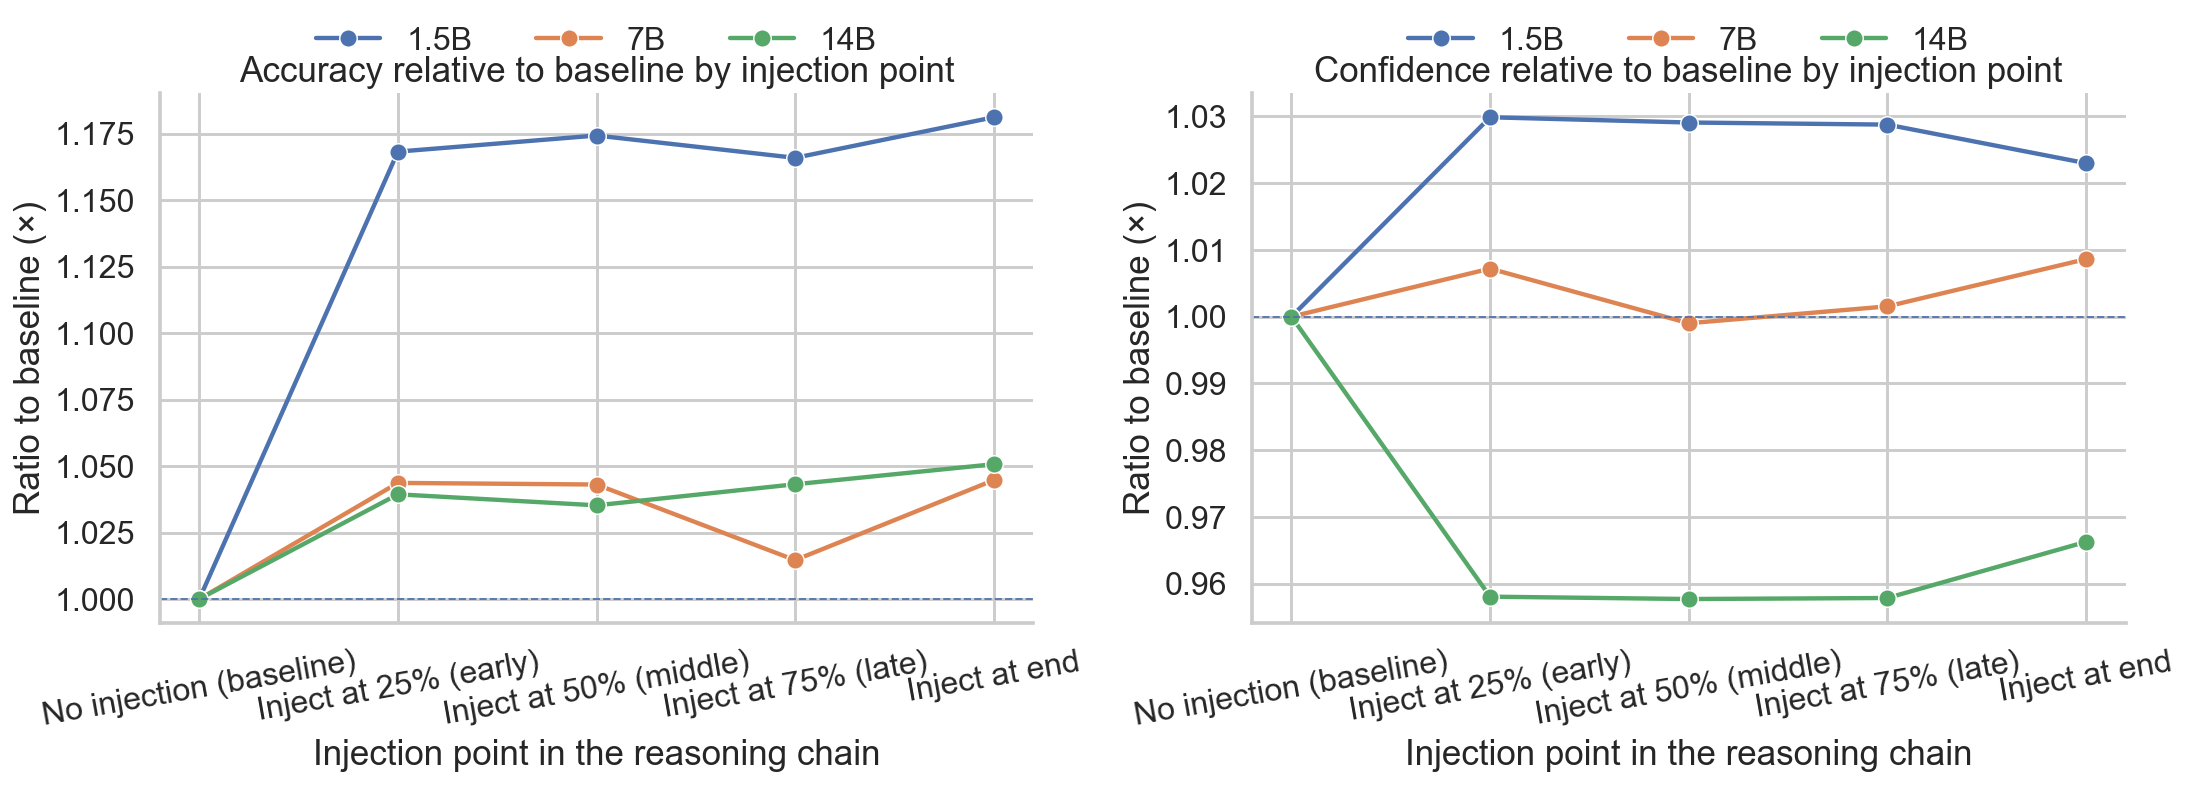

In [11]:
# ---------- relative-to-baseline line charts ----------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Order + friendly labels
exp_order = ["baseline", "1_4", "mid", "3_4", "end"]
exp_long = {
    "baseline": "No injection (baseline)",
    "1_4":      "Inject at 25% (early)",
    "mid":      "Inject at 50% (middle)",
    "3_4":      "Inject at 75% (late)",
    "end":      "Inject at end",
}
size_map   = {"1.5": "1.5B", "7": "7B", "14": "14B"}
size_order = ["1.5B", "7B", "14B"]

# Aggregate to means
agg = (df.groupby(["model_size", "exp"])
         .agg(accuracy=("accuracy", "mean"),
              confidence=("confidence", "mean"))
         .reset_index())

# Label & ordering
agg["model_size_lbl"] = pd.Categorical(agg["model_size"].map(size_map),
                                       categories=size_order, ordered=True)
agg["exp"] = pd.Categorical(agg["exp"], categories=exp_order, ordered=True)
agg["where_injected"] = pd.Categorical(agg["exp"].map(exp_long),
                                       categories=[exp_long[e] for e in exp_order],
                                       ordered=True)

# Baselines per model size
base = (agg[agg["exp"] == "baseline"]
        .rename(columns={"accuracy": "acc_base", "confidence": "conf_base"})
        [["model_size", "acc_base", "conf_base"]])

# Merge and compute ratios (guard against zero baselines)
rel = agg.merge(base, on="model_size", how="left")
rel["acc_rel"]  = np.where(rel["acc_base"]  > 0, rel["accuracy"]  / rel["acc_base"],  np.nan)
rel["conf_rel"] = np.where(rel["conf_base"] > 0, rel["confidence"] / rel["conf_base"], np.nan)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6.5), dpi=140, sharex=True)

# Accuracy ratio
ax = axes[0]
sns.lineplot(
    data=rel.sort_values("exp"),
    x="where_injected", y="acc_rel", hue="model_size_lbl",
    hue_order=size_order, marker="o", ax=ax
)
ax.axhline(1.0, ls="--", lw=1, alpha=0.9)
ax.set_title("Accuracy relative to baseline by injection point")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("Ratio to baseline (×)")
ax.legend(ncol=len(size_order), loc="upper center",
          bbox_to_anchor=(0.5, 1.18), frameon=False)
for t in ax.get_xticklabels(): t.set_rotation(10)

# Confidence ratio
ax = axes[1]
sns.lineplot(
    data=rel.sort_values("exp"),
    x="where_injected", y="conf_rel", hue="model_size_lbl",
    hue_order=size_order, marker="o", ax=ax
)
ax.axhline(1.0, ls="--", lw=1, alpha=0.9)
ax.set_title("Confidence relative to baseline by injection point")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("Ratio to baseline (×)")
ax.legend(
    ncol=len(size_order), loc="upper center",
          bbox_to_anchor=(0.5, 1.18), frameon=False)
for t in ax.get_xticklabels(): t.set_rotation(10)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## AUROC and Brier

/var/folders/q_/1rmphj951kgg57wd05pfgdgc0000gp/T/ipykernel_31479/1160320765.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics = (df.groupby(["model_size", "exp"], as_index=False)
/var/folders/q_/1rmphj951kgg57wd05pfgdgc0000gp/T/ipykernel_31479/1160320765.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(group_metrics)


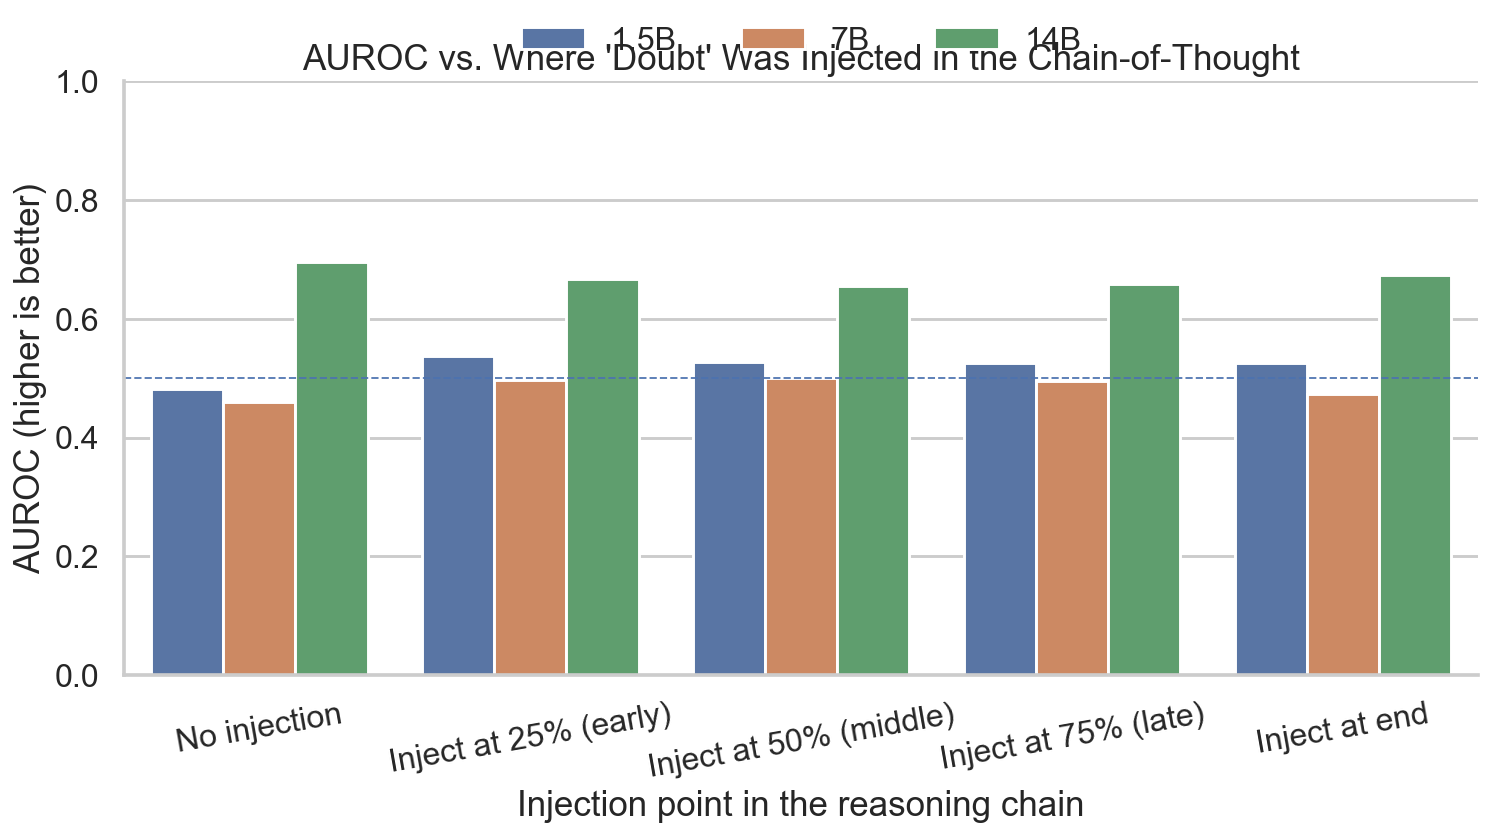

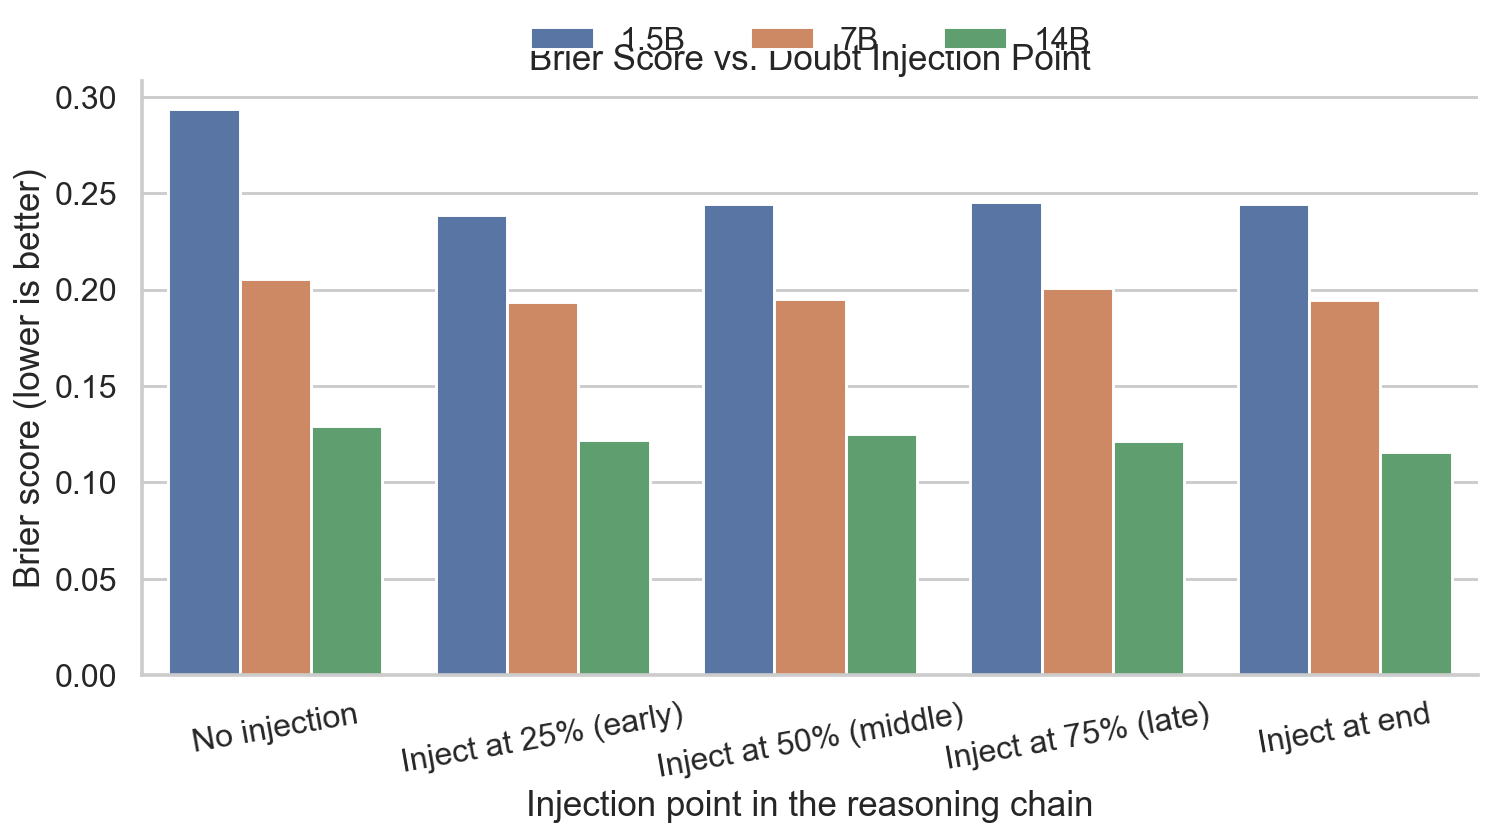

In [13]:
# ---------- AUROC & Brier score bar plots ----------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Friendly labels / order (same story labeling as before)
exp_order = ["baseline", "1_4", "mid", "3_4", "end"]
exp_long = {
    "baseline": "No injection",
    "1_4":      "Inject at 25% (early)",
    "mid":      "Inject at 50% (middle)",
    "3_4":      "Inject at 75% (late)",
    "end":      "Inject at end",
}
size_map   = {"1.5": "1.5B", "7": "7B", "14": "14B"}
size_order = ["1.5B", "7B", "14B"]

# --- helpers ---
def roc_auc_from_ranks(y_true, y_score):
    """
    AUROC via rank formulation (no sklearn/scipy dependency).
    Returns NaN if only one class present.
    """
    y_true = pd.Series(y_true).astype(int)
    if y_true.nunique() < 2:
        return np.nan
    ranks = pd.Series(y_score).rank(method="average")  # average ties
    n_pos = (y_true == 1).sum()
    n_neg = (y_true == 0).sum()
    sum_ranks_pos = ranks[y_true == 1].sum()
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
    return float(auc)

def group_metrics(g):
    y_true = g["accuracy"].astype(int).to_numpy()
    y_hat  = g["confidence"].astype(float).to_numpy()
    brier = np.mean((y_hat - y_true) ** 2)
    auc   = roc_auc_from_ranks(y_true, y_hat)
    return pd.Series({"auroc": auc, "brier": brier})

# Compute metrics per (model_size, exp)
metrics = (df.groupby(["model_size", "exp"], as_index=False)
             .apply(group_metrics)
             .reset_index(drop=True))

# Apply nice labels & ordering
metrics["where_injected"] = pd.Categorical(
    metrics["exp"].map(exp_long),
    categories=[exp_long[e] for e in exp_order],
    ordered=True
)
metrics["model_size_lbl"] = pd.Categorical(
    metrics["model_size"].map(size_map),
    categories=size_order,
    ordered=True
)

# --- AUROC bar plot ---
plt.figure(figsize=(11, 6.8), dpi=140)
ax = sns.barplot(
    data=metrics, x="where_injected", y="auroc",
    hue="model_size_lbl", hue_order=size_order, errorbar=None
)
ax.axhline(0.5, ls="--", lw=1, alpha=0.9)  # no-skill reference
ax.set_ylim(0, 1)
ax.set_title("AUROC vs. Where 'Doubt' Was Injected in the Chain-of-Thought")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("AUROC (higher is better)")
ax.legend(ncol=len(size_order), loc="upper center",
          bbox_to_anchor=(0.5, 1.14), frameon=False)
for t in ax.get_xticklabels(): t.set_rotation(10)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])

# --- Brier score bar plot ---
plt.figure(figsize=(11, 6.8), dpi=140)
ax = sns.barplot(
    data=metrics, x="where_injected", y="brier",
    hue="model_size_lbl", hue_order=size_order, errorbar=None
)
ax.set_title("Brier Score vs. Doubt Injection Point")
ax.set_xlabel("Injection point in the reasoning chain")
ax.set_ylabel("Brier score (lower is better)")
ax.legend(ncol=len(size_order), loc="upper center",
          bbox_to_anchor=(0.5, 1.14), frameon=False)
for t in ax.get_xticklabels(): t.set_rotation(10)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


## Len of CoT

ValueError: Could not interpret value `exp_label` for `hue`. An entry with this name does not appear in `data`.

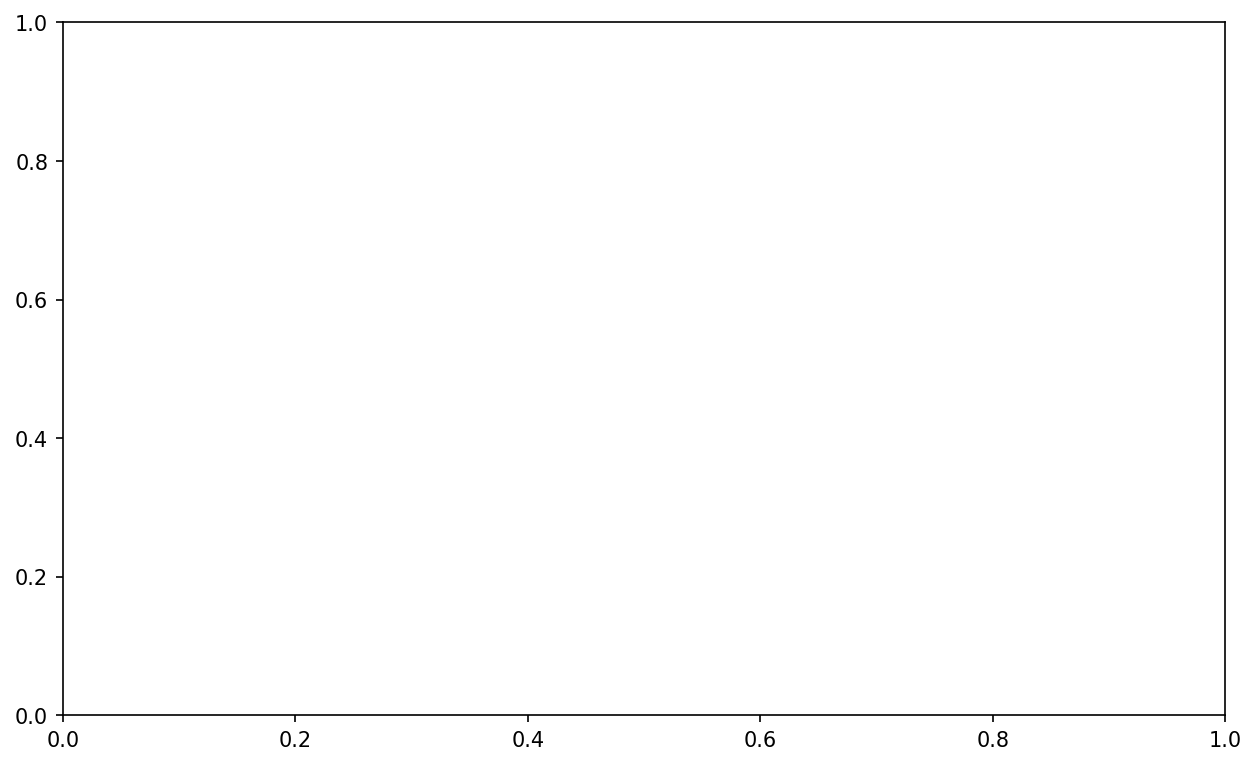

In [2]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Seaborn will create the legend from `hue` here
sns.histplot(
    data=df,
    x="len_reason",
    hue="exp_label",
    hue_order=["baseline", "1/4", "mid", "3/4", "end"],
    bins=80,
    stat="density",
    common_norm=False,
    multiple="layer",
    element="step",
    # fill=False,
    binrange=(0, 3000),
    linewidth=1.5,
    legend=True,      # <- ensure legend is on
    ax=ax
)

# Keep KDEs out of the legend to avoid duplicates
sns.kdeplot(
    data=df,
    x="len_reason",
    hue="exp_label",
    hue_order=["baseline", "1/4", "mid", "3/4", "end"],
    common_norm=False,
    clip=(0, 3000),
    lw=2,
    legend=False,
    ax=ax
)

ax.set_xlim(0, 3000)
ax.set_xlabel("Reasoning length")
ax.set_ylabel("Density")
ax.set_title("Distribution of reasoning length by position")

# Move/style the existing legend
sns.move_legend(ax, "upper right", title="Position", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


## 

## Confidence Histograms

/var/folders/q_/1rmphj951kgg57wd05pfgdgc0000gp/T/ipykernel_34840/2855176607.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


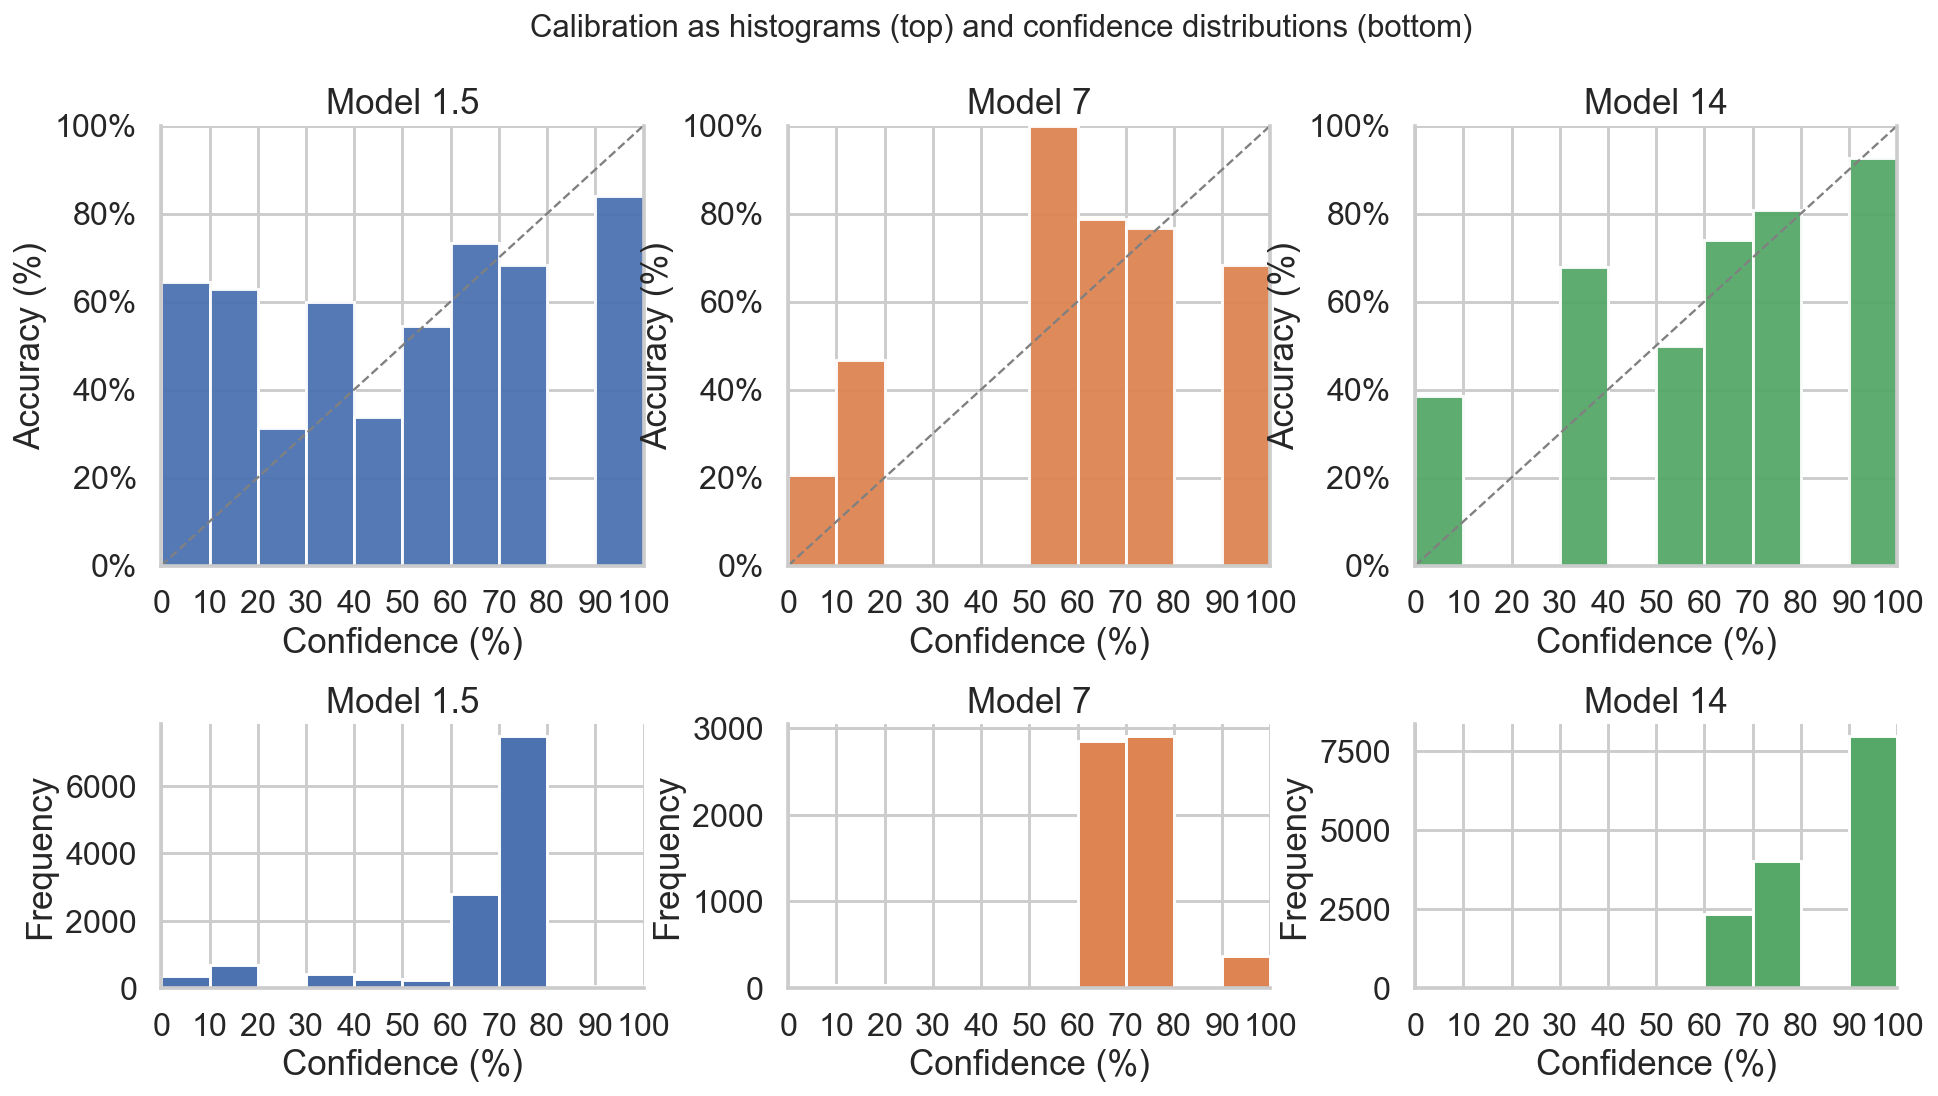

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sns.set_theme(style="whitegrid", context="talk")

model_order = ["1.5", "7", "14"]
palette = sns.color_palette("deep", n_colors=len(model_order))
color_map = dict(zip(model_order, palette))

# Ensure types and clamp confidence
df_use = df.copy()
df_use["model_size"] = pd.Categorical(df_use["model_size"], categories=model_order, ordered=True)
df_use["accuracy"] = df_use["accuracy"].astype(int)
df_use["conf_pct"] = (df_use["confidence"].clip(0, 1) * 100)

# Fixed, shared bin edges and labels
edges = np.arange(0, 110, 10)  # 0,10,...,100
df_use["conf_bin"] = pd.cut(df_use["conf_pct"], bins=edges, right=False, include_lowest=True)

# Aggregate accuracy and counts per bin
calib = (
    df_use.groupby(["model_size", "conf_bin"], observed=True)
          .agg(acc=("accuracy", "mean"), n=("accuracy", "size"))
          .reset_index()
)
calib["acc_pct"] = calib["acc"] * 100
calib["left"]    = calib["conf_bin"].apply(lambda iv: iv.left)
calib["width"]   = calib["conf_bin"].apply(lambda iv: iv.right - iv.left)

# ----------------- Figure layout -----------------
fig = plt.figure(figsize=(16, 8), dpi=140)
gs  = fig.add_gridspec(2, 3, height_ratios=[2.0, 1.2], hspace=0.45, wspace=0.3)

# -------- Top row: calibration as histogram bars + count overlay (same bins) --------
for i, ms in enumerate(model_order):
    ax = fig.add_subplot(gs[0, i])
    sub = calib[calib["model_size"] == ms]

    # Calibration bars (Accuracy % per confidence bin)
    ax.bar(
        sub["left"], sub["acc_pct"], width=sub["width"],
        align="edge", color=color_map[ms], edgecolor="white", alpha=0.95
    )

    # Perfect calibration reference
    ax.plot([0, 100], [0, 100], ls="--", lw=1.2, color="gray")

    # # Twin axis: counts with identical bins (ensures perfect alignment)
    # ax2 = ax.twinx()
    # ax2.bar(
    #     sub["left"], sub["n"], width=sub["width"],
    #     align="edge", color=color_map[ms], alpha=0.18, edgecolor="none"
    # )
    # ax2.set_ylabel("Frequency")
    # ax2.grid(False)

    # Cosmetics
    ax.set_title(f"Model {ms}")
    ax.set_xlabel("Confidence (%)")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks(edges)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    sns.despine(ax=ax, right=False)
    sns.despine(ax=ax2, left=True)

# -------- Bottom row: confidence histograms side by side (same edges) --------
for i, ms in enumerate(model_order):
    axh = fig.add_subplot(gs[1, i])
    sub_df = df_use[df_use["model_size"] == ms]
    axh.hist(sub_df["conf_pct"], bins=edges, color=color_map[ms], edgecolor="white")
    axh.set_title(f"Model {ms}")
    axh.set_xlabel("Confidence (%)")
    axh.set_ylabel("Frequency")
    axh.set_xlim(0, 100)
    axh.set_xticks(edges)
    sns.despine(ax=axh)

fig.suptitle("Calibration as histograms (top) and confidence distributions (bottom)", y=0.98, fontsize=16)
plt.tight_layout()
plt.show()
